In [54]:
# Please execute/shift-return this cell everytime you run the notebook.  Don't edit it. 
%load_ext autoreload
%autoreload 2
from notebook import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Amdahl's Law

## The starting example -- sorting

In [39]:
render_code("./gpusort/main.cu", show="main")

// ./gpusort/main.cu:516-682 (167 lines)
int main( int argc, char** argv)
{ 

  // Create timers for each sort
    struct timeval time_start, time_end, program_start, program_end;
    double input_time=0;
    gettimeofday(&program_start, NULL);	

    sdkCreateTimer(&uploadTimer);
    sdkCreateTimer(&downloadTimer);
    sdkCreateTimer(&bucketTimer);
    sdkCreateTimer(&mergeTimer);
    sdkCreateTimer(&totalTimer);
    sdkCreateTimer(&cpuTimer);
	int numElements = 0;
	int method=0;
    // Number of elements in the test bed
    	gettimeofday(&time_start, NULL);
#ifdef READING_FROM_BINARY
        numElements = atoi(argv[2]);
	if (argc == 4)
		method = atoi(argv[3]);
#else
       	if(strcmp(argv[1],"r") ==0) {
	         numElements = SIZE; 
	    }
	else {
		FILE *fp;
	    fp = fopen(argv[1],"r");
	    if(fp == NULL) {
	        cout << "Error reading file" << endl;
	        exit(EXIT_FAILURE);
	    }
	    int count = 0;
	    float c;

	    while(fscanf(fp,"%f",&c) != EOF) {
	        count++;
        }
	    fclose(fp);
	    numElements = count;
    }
#endif

	cout << "Sorting list of " << numElements << " floats\n";
	// Generate random data
	// Memory space the list of random floats will take up
	int mem_size = numElements * sizeof(float); 
	// Allocate enough for the input list
	float *cpu_idata = (float *)malloc(mem_size);
	// Allocate enough for the output list on the cpu side
	float *cpu_odata = (float *)malloc(mem_size);
	// Allocate enough memory for the output list on the gpu side
	float *gpu_odata = (float *)malloc(mem_size);

	float datamin = FLT_MAX; 
	float datamax = -FLT_MAX; 
	if(strcmp(argv[1],"r")==0) {

	for (int i = 0; i < numElements; i++) {
	// Generate random floats between 0 and 1 for the input data
		cpu_idata[i] = ((float) rand() / RAND_MAX); 
	//Compare data at index to data minimum, if less than current minimum, set that element as new minimum
		datamin = min(cpu_idata[i], datamin);
	//Same as above but for maximum
		datamax = max(cpu_idata[i], datamax);
	}
    }	else {
	FILE *fp;
#ifdef READING_FROM_BINARY
	fp = fopen(argv[1],"rb");
	fread(cpu_idata,sizeof(float),numElements,fp);
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
	
    /*	for(int i = 0; i < numElements; i++) {
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}*/

	datamin = 0.0;
	datamax = 16777215.0;
#else
	fp = fopen(argv[1],"r");
	for(int i = 0; i < numElements; i++) {
	fscanf(fp,"%f",&cpu_idata[i]);
	datamin = min(cpu_idata[i],datamin);
	datamax = max(cpu_idata[i],datamax);
	}
	fclose(fp);
   	gettimeofday(&time_end, NULL);
    input_time = ((time_end.tv_sec * 1000000 + time_end.tv_usec) - (time_start.tv_sec * 1000000 + time_start.tv_usec))/1000000.0;
	printf("FileInput %lf seconds\n",input_time);
    	gettimeofday(&time_start, NULL);	
#endif
	}
#ifndef CPU
	cout << "Sorting on GPU..." << flush; 
	// GPU Sort
	if(method == 0)
	for (int i = 0; i < TEST; i++) 
        MergeSort(cpu_idata, numElements, THREADS_PER_BLOCK, numElements/THREADS_PER_BLOCK);
//		gpu_quicksort(cpu_idata, gpu_odata, numElements);		
	else {
	// Using bitonic sort
	for (int i = 0; i < TEST; i++) 
		bitonic_sort(cpu_idata, gpu_odata, numElements);		
	}
#endif

#if defined(VERIFY) || (defined CPU)
	cout << "Sorting on CPU..." << flush; 
	// Start_CPU_Sort
	sdkStartTimer(&cpuTimer); 
	memcpy(cpu_odata, cpu_idata, mem_size);
    qsort(cpu_odata, numElements, sizeof(float), compare);
	sdkStopTimer(&cpuTimer); 
    // End_CPU_Sort 
	cout << "done.\n";
	#ifdef VERIFY
    cout << "Checking result..." << flush; 
	// Result checking
	int count = 0; 
	for(int i = 0; i < numElements; i++)
		if(fabs(cpu_odata[i] - gpu_odata[i])> 0.0002)
		{
			printf("Sort missmatch on element %d: \n", i); 
			printf("CPU = %f : GPU = %f\n", cpu_odata[i], gpu_odata[i]); 
			count++; 
			break; 
		}

## Where is the most time critical part of my program?

In [40]:
! cd gpusort; make clean; make
! echo "File on H.D.D.; Sorting on CPU"
! ssh htseng@azelf "cd courses/CS203/demo/amdahlslaw/gpusort; echo \"ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host\" > sort.csv; source ./run_CPU 2>> sort.csv"

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on CPU
Sorting list of 134217728 floats
FileInput 3.190858 seconds
Sorting on CPU...done.
Total CPU execution time: 14.749002 seconds


In [41]:
display_df_mono(render_csv("./gpusort/sort.csv", columns=["ET","FileInput","CPU_Kernel"]))

,ET,FileInput,CPU_Kernel
0,17.939939,3.190858,14.749002


In [42]:
! ssh htseng@azelf "lscpu"

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   39 bits physical, 48 bits virtual
CPU(s):                          24
On-line CPU(s) list:             0-23
Thread(s) per core:              1
Core(s) per socket:              16
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           151
Model name:                      12th Gen Intel(R) Core(TM) i9-12900KF
Stepping:                        2
CPU MHz:                         600.423
CPU max MHz:                     6700.0000
CPU min MHz:                     800.0000
BogoMIPS:                        6374.40
Virtualization:                  VT-x
L1d cache:                       384 KiB
L1i cache:                       256 KiB
L2 cache:                        10 MiB
NUMA node0 CPU(s):              

### Use gprof to figure out the timing breakdown

In [ ]:
! cd gpusort; make clean; make EXTRA_FLAGS=-pg 
! ssh htseng@azelf "cd courses/CS203/demo/amdahlslaw/gpusort; source ./run_CPU"

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -pg  -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w -pg  -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
Sorting list of 134217728 floats
FileInput 3.197242 seconds
Sorting on CPU...

In [ ]:
! cd gpusort; gprof ./hybridsort_cpu ./gmon.out

## Amdahl's Law -- optimizating is a moving target

In [45]:
render_code("./gpusort/main.cu", lang="c++", show="bitonic_sort")

// ./gpusort/main.cu:63-92 (30 lines)
void bitonic_sort(float *values, float *out_values, int num_of_elements)
{
  float *dev_values;
  size_t size = num_of_elements * sizeof(float);
  int BLOCKS = num_of_elements/THREADS_PER_BLOCK; 

  cudaMalloc((void**) &dev_values, size);
  sdkStartTimer(&uploadTimer);
  cudaMemcpy(dev_values, values, size, cudaMemcpyHostToDevice);
  sdkStopTimer(&uploadTimer); 
  dim3 blocks(BLOCKS,1);    /* Number of blocks   */
  dim3 threads(THREADS_PER_BLOCK,1);  /* Number of threads  */

  sdkStartTimer(&totalTimer); 
  int j, k;
  /* Major step */
  for (k = 2; k <= num_of_elements; k <<= 1) {
    /* Minor step */
    for (j=k>>1; j>0; j=j>>1) {
      bitonic_sort_step<<<blocks, threads>>>(dev_values, j, k);
    }
  }
		cudaThreadSynchronize(); 
  sdkStopTimer(&totalTimer); 
  sdkStartTimer(&downloadTimer);
  cudaMemcpy((void *)out_values, (void *)dev_values,  num_of_elements*sizeof(float), cudaMemcpyDeviceToHost);
//		checkCudaErrors(cudaMemcpy((void *)out_values, (void *)dev_values, num_of_elements*sizeof(float), cudaMemcpyDeviceToHost));
  sdkStopTimer(&downloadTimer); 
  cudaFree(dev_values);
}

In [46]:
! ssh htseng@azelf "nvidia-smi -a"


==============NVSMI LOG==============

Timestamp                                 : Mon Oct 10 10:04:36 2022
Driver Version                            : 515.43.04
CUDA Version                              : 11.7

Attached GPUs                             : 1
GPU 00000000:01:00.0
    Product Name                          : NVIDIA GeForce RTX 3090
    Product Brand                         : GeForce
    Product Architecture                  : Ampere
    Display Mode                          : Disabled
    Display Active                        : Disabled
    Persistence Mode                      : Enabled
    MIG Mode
        Current                           : N/A
        Pending                           : N/A
    Accounting Mode                       : Disabled
    Accounting Mode Buffer Size           : 4000
    Driver Model
        Current                           : N/A
        Pending                           : N/A
    Serial Number                         : 1324020004369
    GPU U

In [47]:
! cd gpusort; make clean; make
# ! ssh htseng@azelf "source ./courses/CS203/demo/amdahlslaw/gpusort/run_CPU"
! echo "File on H.D.D.; Sorting on GPU"
! ssh htseng@azelf "cd courses/CS203/demo/amdahlslaw/gpusort; source ./run 2>> sort.csv"
! echo "File on S.S.D.; Sorting on GPU"
! ssh htseng@azelf "cd courses/CS203/demo/amdahlslaw/gpusort; source ./run_SSD 2>> sort.csv"

rm -f	*.o hybridsort hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DCPU -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort_cpu
/usr/local/cuda/bin/nvcc -DTIMER -O3 -w   -DHAVE_LINUX_PERF_EVENT_H -DREADING_FROM_BINARY         main.cu -o hybridsort
File on H.D.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 3.202314 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.443494 seconds
    - Upload		: 0.055897 seconds
    - Download		: 0.137789 seconds
File on S.S.D.; Sorting on GPU
Sorting list of 134217728 floats
FileInput 0.597248 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.446033 seconds
    - Upload		: 0.050648 seconds
    - Download		: 0.137494 seconds


In [48]:
display_df_mono(render_csv("./gpusort/sort.csv"))

,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,17.939939,3.190858,14.749002,0.000000,0.000000,0.000000
1,4.002343,3.202314,0.000000,0.443494,0.055897,0.137789
2,1.408809,0.597248,0.000000,0.446033,0.050648,0.137494


## Amdahl's Law on parallel programming

In [49]:
! cd vmul; make clean; make
! echo "THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST" > ./vmul/vmul.csv
! echo "CPU based vul"
! ssh htseng@azelf "time ./courses/CS203/demo/amdahlslaw/vmul/vmul 33554432 1 0 30 2>> ./courses/CS203/demo/amdahlslaw/vmul/vmul.csv"
! echo "GPU based vul"
### i stands for "How many iterations each thread performs 
### -- the larger the number, the fewer the parallelism
! for i in 1 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192; do ssh htseng@azelf "time ./courses/CS203/demo/amdahlslaw/vmul/vmul 33554432 $i 1 30 2>> ./courses/CS203/demo/amdahlslaw/vmul/vmul.csv" ; done

rm -f vmul *.o
gcc -O3 vmul.c -c
gcc -O3 vmul_cpu.c -c
/usr/local/cuda/bin/nvcc -O3 -w vmul_cuda.cu -c
gcc -O3 *.o -lcuda -lcudart -L/usr/local/cuda/lib64 -o vmul
CPU based vul
Using CPU
kernel: 0.539398 seconds

real	0m1.101s
user	0m0.963s
sys	0m0.117s
GPU based vul
memcpy (to device): 0.224852 seconds
Using GPU
kernel: 0.004760 seconds
memcpy (to host): 0.024394 seconds

real	0m0.805s
user	0m0.525s
sys	0m0.193s
memcpy (to device): 0.141493 seconds
Using GPU
kernel: 0.009674 seconds
memcpy (to host): 0.024186 seconds

real	0m0.532s
user	0m0.352s
sys	0m0.126s
memcpy (to device): 0.144808 seconds
Using GPU
kernel: 0.019872 seconds
memcpy (to host): 0.024284 seconds

real	0m0.540s
user	0m0.344s
sys	0m0.138s
memcpy (to device): 0.091594 seconds
Using GPU
kernel: 0.040196 seconds
memcpy (to host): 0.024172 seconds

real	0m0.587s
user	0m0.436s
sys	0m0.139s
memcpy (to device): 0.146157 seconds
Using GPU
kernel: 0.126549 seconds
memcpy (to host): 0.024313 seconds

real	0m0.675s
user	0m0.488s


,THREADS,CPUTIME,HOST2GPU,GPUTIME,GPU2HOST,TOTAL
0,0.000000,0.539398,0.000000,0.000000,0.000000,0.539398
14,4.000000,0.000000,0.161746,0.410434,0.024236,0.596416
13,8.000000,0.000000,0.140493,0.206763,0.024187,0.371443
12,16.000000,0.000000,0.169611,0.102903,0.032987,0.305501
11,32.000000,0.000000,0.107130,0.200022,0.024554,0.331706
10,64.000000,0.000000,0.161647,0.317636,0.024393,0.503676
9,128.000000,0.000000,0.161407,0.284272,0.024330,0.470009
8,256.000000,0.000000,0.147073,0.321018,0.024243,0.492334
7,512.000000,0.000000,0.107718,0.196609,0.024160,0.328487
6,1024.000000,0.000000,0.223268,0.179345,0.032964,0.435577


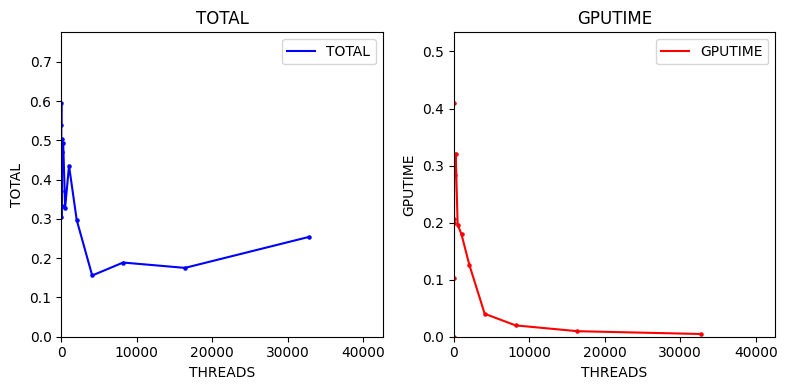

In [50]:
df = render_csv("./vmul/vmul.csv")
df["TOTAL"] = df["CPUTIME"] + df["HOST2GPU"] + df["GPUTIME"] + df["GPU2HOST"]
df = df.sort_values(by=["THREADS"], ascending=True)
display_df_mono(df)
plotPE(df=df, lines=True, what=[ ('THREADS', "TOTAL"), ('THREADS', "GPUTIME")], columns=2)

# Choose the "right" metrics

## Throughput and Latency

### SSD v.s. HDD

You may use to hdparm (need root permission to execute). The /dev/sda on this machine is an SATA SSD that has around 450-500MB/sec bandwidth. The /dev/md0 is a RAID contains two H.D.Ds in RAID-0 configuration that also achieves 450-500MB/sec bandwidth. Let's examine the bandwidth using the following command.

In [51]:
from IPython.display import IFrame
IFrame("https://hub.escalab.org:8000/user/htseng/terminals/1", width="100%", height="400")

Now, let's revisit the optimized gpusort on this machine with different array size...

In [52]:
! echo "Configuration,Size,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host" > sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 512 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 512 2>> ../sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 32768 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 32768 2>> ../sort_small.csv
! echo "File on H.D.D"
! cd gpusort; source ./run_small 262144 2>> ../sort_small.csv
! echo "File on S.S.D"
! cd gpusort; source ./run_small_SSD 262144 2>> ../sort_small.csv
display_df_mono((render_csv("sort_small.csv")))

File on H.D.D
Sorting list of 512 floats
FileInput 0.003963 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.000050 seconds
    - Upload		: 0.117543 seconds
    - Download		: 0.000045 seconds
Sorting list of 512 floats
FileInput 0.005140 seconds
Sorting on CPU...done.
Total CPU execution time: 0.000203 seconds
File on S.S.D
Sorting list of 512 floats
FileInput 0.002969 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.000047 seconds
    - Upload		: 0.123672 seconds
    - Download		: 0.000042 seconds
Sorting list of 512 floats
FileInput 0.003681 seconds
Sorting on CPU...done.
Total CPU execution time: 0.000189 seconds
File on H.D.D
Sorting list of 32768 floats
FileInput 0.004952 seconds
Sorting on GPU...GPU iterations: 1
Total GPU Sort execution time: 0.001439 seconds
    - Upload		: 0.116926 seconds
    - Download		: 0.000261 seconds
Sorting list of 32768 floats
FileInput 0.004708 seconds
Sorting on CPU...done.
Total CPU execution ti

,Configuration,Size,ET,FileInput,CPU_Kernel,GPU_Kernel,Host2GPU,GPU2Host
0,HDD+GPU,512,0.738578,0.003963,0.000000,0.000050,0.117543,0.000045
1,HDD+CPU,512,0.005483,0.005140,0.000203,0.000000,0.000000,0.000000
2,SSD+GPU,512,0.967840,0.002969,0.000000,0.000047,0.123672,0.000042
3,SSD+CPU,512,0.004018,0.003681,0.000189,0.000000,0.000000,0.000000
4,HDD+GPU,32768,0.524456,0.004952,0.000000,0.001439,0.116926,0.000261
5,HDD+CPU,32768,0.012971,0.004708,0.008206,0.000000,0.000000,0.000000
6,SSD+GPU,32768,0.424379,0.002875,0.000000,0.001332,0.122492,0.000237
7,SSD+CPU,32768,0.011454,0.004156,0.007208,0.000000,0.000000,0.000000
8,HDD+GPU,262144,0.805372,0.023789,0.000000,0.002156,0.106064,0.001497
9,HDD+CPU,262144,0.051223,0.020188,0.030994,0.000000,0.000000,0.000000


What can we observe here?

## Inference per second

Inference per second is frequently used for ML performance, is it a good "metric"? Let's try using Google's edge TPU and compare it with CPU performance!

In [ ]:
!ssh htseng@celebi "python3 /nfshome/htseng/ESCAL/pycoral/benchmarks/inference_benchmarks.py"